In [35]:
import tensorflow as tf

In [36]:
print(tf.__version__)

2.16.1


In [37]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [38]:
df =  pd.read_csv('Brent_Oil_Futures_Historical_Data.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/27/1988,15.10,15.10,15.10,15.10,0.05K,-3.51%
1,06/28/1988,15.27,15.34,15.36,15.27,0.16K,1.13%
2,06/29/1988,15.47,15.47,15.47,15.47,NaN,1.31%
3,06/30/1988,14.85,14.80,14.90,14.80,0.42K,-4.01%
4,07/01/1988,14.60,14.60,14.60,14.60,0.05K,-1.68%


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9129 entries, 0 to 9128
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      9129 non-null   object 
 1   Price     9129 non-null   float64
 2   Open      9129 non-null   float64
 3   High      9129 non-null   float64
 4   Low       9129 non-null   float64
 5   Vol.      9123 non-null   object 
 6   Change %  9129 non-null   object 
dtypes: float64(4), object(3)
memory usage: 499.4+ KB


In [40]:
unit_mapping = {'K': 1000}

def convert_to_numeric(value):
    if isinstance(value, str) and value[-1] in unit_mapping:
        unit = value[-1]
        number = float(value[:-1])
        return number * unit_mapping[unit]
    elif isinstance(value, str):
        return float(value)
    else:
        return value

def remove_percentage(value):
    if isinstance(value, str) and value[-1] == '%':
        return float(value[:-1])
    else:
        return value

df['Change %'] = df['Change %'].apply(remove_percentage)
df['Vol.'] = df['Vol.'].apply(convert_to_numeric)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/27/1988,15.10,15.10,15.10,15.10,50.0,-3.51
1,06/28/1988,15.27,15.34,15.36,15.27,160.0,1.13
2,06/29/1988,15.47,15.47,15.47,15.47,NaN,1.31
3,06/30/1988,14.85,14.80,14.90,14.80,420.0,-4.01
4,07/01/1988,14.60,14.60,14.60,14.60,50.0,-1.68


In [41]:
imputer = SimpleImputer(strategy='mean')
df['Vol.'] = imputer.fit_transform(df[['Vol.']])

In [42]:
df.reset_index(drop=True, inplace=True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9129 entries, 0 to 9128
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      9129 non-null   object 
 1   Price     9129 non-null   float64
 2   Open      9129 non-null   float64
 3   High      9129 non-null   float64
 4   Low       9129 non-null   float64
 5   Vol.      9129 non-null   float64
 6   Change %  9129 non-null   float64
dtypes: float64(6), object(1)
memory usage: 499.4+ KB


In [44]:
train_size = int(len(df) * 0.8)
training_data = df[:train_size]
testing_data = df[train_size:]

In [45]:
x_train_cols = training_data.iloc[:, 1:7].values  
y_train_col = training_data.iloc[:, 1].values

In [46]:
sc = MinMaxScaler(feature_range=(0,1))
x_train_scaled = sc.fit_transform(x_train_cols)

In [47]:
with open('./models/GRUs.pkl', 'wb') as f:
    pickle.dump(sc, f)

In [48]:
x_train_scaled

array([[4.00175901e-02, 3.95314788e-02, 3.74409306e-02, 4.12026726e-02,
        8.62440707e-05, 6.40311348e-01],
       [4.12635591e-02, 4.12884334e-02, 3.93311523e-02, 4.24647365e-02,
        3.23415265e-04, 7.35354363e-01],
       [4.27294049e-02, 4.22401171e-02, 4.01308615e-02, 4.39495174e-02,
        2.40647380e-01, 7.39041376e-01],
       ...,
       [3.37950748e-01, 3.37628111e-01, 3.36604871e-01, 3.41573868e-01,
        5.87559293e-01, 7.04219582e-01],
       [3.37217825e-01, 3.37042460e-01, 3.36532170e-01, 3.38381589e-01,
        6.70181113e-01, 7.08521098e-01],
       [3.38390501e-01, 3.36969253e-01, 3.33914940e-01, 3.38158872e-01,
        5.83182406e-01, 7.18148300e-01]])

In [49]:
x_train = []
y_train = []

for i in range(60, len(training_data) - 1):
    x_train.append(x_train_scaled[i-60:i+1, :]) 
    y_train.append(y_train_col[i+1])

x_train, y_train = np.array(x_train), np.array(y_train)

In [50]:
x_train

array([[[4.00175901e-02, 3.95314788e-02, 3.74409306e-02, 4.12026726e-02,
         8.62440707e-05, 6.40311348e-01],
        [4.12635591e-02, 4.12884334e-02, 3.93311523e-02, 4.24647365e-02,
         3.23415265e-04, 7.35354363e-01],
        [4.27294049e-02, 4.22401171e-02, 4.01308615e-02, 4.39495174e-02,
         2.40647380e-01, 7.39041376e-01],
        ...,
        [3.00498388e-02, 2.92825769e-02, 2.84987277e-02, 3.07349666e-02,
         3.49288486e-03, 6.81278165e-01],
        [2.79976546e-02, 2.70131772e-02, 2.54452926e-02, 2.73199703e-02,
         4.26908150e-03, 6.70421958e-01],
        [2.90237467e-02, 2.79648609e-02, 2.72628135e-02, 2.94729027e-02,
         1.18585597e-03, 7.33510856e-01]],

       [[4.12635591e-02, 4.12884334e-02, 3.93311523e-02, 4.24647365e-02,
         3.23415265e-04, 7.35354363e-01],
        [4.27294049e-02, 4.22401171e-02, 4.01308615e-02, 4.39495174e-02,
         2.40647380e-01, 7.39041376e-01],
        [3.81852829e-02, 3.73352855e-02, 3.59869138e-02, 3.897550

In [51]:
y_train

array([13.52, 13.58, 13.52, ..., 55.75, 55.65, 55.81])

In [52]:
x_train.shape

(7242, 61, 6)

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(61, 6)),
    tf.keras.layers.GRU(units=60, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=60, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=80, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=120, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 61, 60)         │        12,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 61, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 61, 60)         │        21,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 61, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 61, 80)         │        34,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 61, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 120)            │        72,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,121 (551.25 KB)

 Trainable params: 141,121 (551.25 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
checkpoint = ModelCheckpoint('./models/GRUs.keras', monitor='loss', verbose=1, save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logs'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [55]:
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))

In [56]:
model.fit(x_train, y_train, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1619.5460
Epoch 1: loss improved from inf to 628.02618, saving model to ./models/GRUs.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1602.3022 - learning_rate: 0.0010
Epoch 2/150
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 40.8304
Epoch 2: loss improved from 628.02618 to 38.17917, saving model to ./models/GRUs.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 40.7843 - learning_rate: 0.0010
Epoch 3/150
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 35.3916
Epoch 3: loss improved from 38.17917 to 36.72831, saving model to ./models/GRUs.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 35.4149 - learning_rate: 0.0010
Epoch 4/150
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 31.2619
Epoch 4: loss improved from 36.72831 to 33.86746, saving model to ./models/GRUs.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 31.3072 - learning_rate: 0.0010
Epoch 5/150
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 76

In [57]:
real_price = testing_data.iloc[:, 1].values

In [58]:
real_price.shape

(1826,)

In [59]:
predictions = []
for i in range(len(testing_data)):
    input_data_test = testing_data.iloc[i, 1:7].values.reshape(1, -1).repeat(61, axis=0) 
    input_data_test_scaled = sc.transform(input_data_test).reshape(1, 61, 6)
    predicted_price_test = model.predict(input_data_test_scaled)
    predictions.append(predicted_price_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

In [60]:
predictions = np.array(predictions).reshape(-1)

In [61]:
print(predictions[0]), print(real_price[0])

50.952145
56.18


(None, None)

In [62]:
mae = mean_absolute_error(real_price, predictions)
mse = mean_squared_error(real_price, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

Mean Absolute Error (MAE): 6.2975549183539465
Mean Squared Error (MSE): 42.10337926874373
Root Mean Squared Error (RMSE): 6.4887116801984455
R-squared (R²): 0.875905616528631


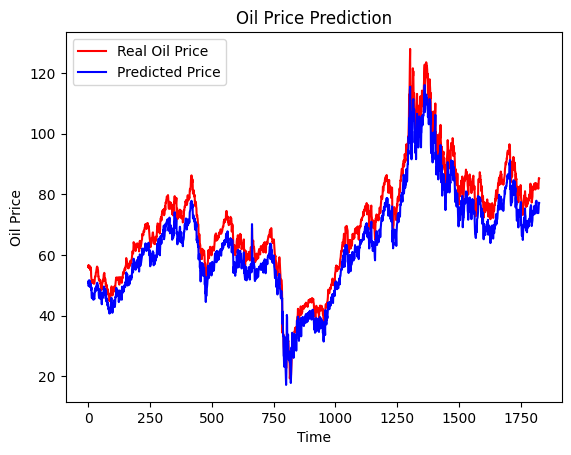

In [65]:
plt.plot(real_price, color='red', label='Real Oil Price')
plt.plot(predictions, color='blue', label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.legend()
plt.show()

In [ ]:
input_data_test = []
for i in range(6):
    feature = float(input(f"Enter value for feature {i+1}: "))
    input_data_test.append(feature)
    
testing_data = pd.Series(input_data_test, index=['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'])

In [ ]:
input_data_test = testing_data.values.reshape(1, -1).repeat(61, axis=0) 
input_data_test_scaled = sc.transform(input_data_test)
predicted_price_test = model.predict(np.array([input_data_test_scaled]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
predicted_price_test = np.array(predicted_price_test).reshape(-1)

In [ ]:
predicted_price_test[0]

15.974119